In [1]:
#Jakovs Kaplans
#2427546K
#MSc Data Analytics Year 2

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [402]:
class Node:
    #The class node represents a single node. It sets ID, location, bonds and statistics
    
    _id_counter = 0
    def __init__(self, x, y, child = []):
        self.x = x # x location of the node
        self.y = y # y location of the node
        self.child = child #child nodes
        self.occupied = 0 #is the car inside the segment, 0 or 1
        self.flow = 0 #flow statistics
        self.id = self._issue_id() #issue ID number
        
    @classmethod
    def _issue_id(cls):
        new_id = cls._id_counter # Store id counter so that it can be returned
        cls._id_counter += 1 # Increment id counter
        return new_id
        
    def __repr__(self):
        return  "ID {} at X:{}, Y:{}, occupied: {}, connected to ID_{}.".format(self.id, round(self.x), round(self.y),self.occupied,[c.id for c in self.child]) 
    
    def __str__(self):
        return "ID_{} {},{}".format(self.id, round(self.x), round(self.y))    
        
    def move(self):
        
        #For one segment
        if len(self.child) == 1:
            if self.occupied == 1 and self.child[0].occupied == 0: #If child is unoccupied and self is occupied
                self.child[0].occupied = 1 #move occupied to the child
                self.occupied = 0 #set segment to unoccupied
                self.flow += 1 #increment the flow statistics
                
        #For more segments
        if len(self.child) > 1: #if children number more then 1
            index = random.choice(range(len(self.child))) #select random child
            
            if self.occupied == 1 and self.child[index].occupied == 0: #If child is unoccupied and self is occupied
                self.child[index].occupied = 1 #move occupied to the child
                self.occupied = 0  #set segment to unoccupied
                self.flow += 1 #increment the flow statistics
    
    def to_dict(self):
        #Translate attributes to the dictionary
        return {
            'x': self.x,
            'y': self.y,
            'occupied': self.occupied,
            'flow': self.flow,
            'child': self.child
        }


In [ ]:
class Network:
    #The class network creates multiple nodes by taking dataframes, producing movements and statistics across all nodes
    
    def __init__(self,nodes_path, edges_path, pdeath = 0.001, pbirth = 0.001):
        nodes = pd.read_csv(nodes_path) #read the nodes data into dataframe
        edges = pd.read_csv(edges_path) #read the nodes data into dataframe
        
        #Check whether pbirth and pdeath are valid probs
        if (pdeath < 0 or pbirth < 0) and (pdeath > 1 or pbirth > 1): 
            raise ValueError("Probabilities must be greater or equal to zero and less or equal to 1")
        
        #Check if nodes dataframe has necessary columns
        if 'x' and 'y' not in nodes.columns:
            raise ValueError("Dataframe of nodes must contain 'x' and 'y' columns")
        
        #Check if edges dataframe has necessary columns
        if 'to' and 'from' not in edges.columns:
            raise ValueError("Dataframe of edges must contain 'to' and 'from' columns")
        
        self.pdeath = pdeath #probs of random death
        self.pbirth = pbirth #probs of random birth
        self.nodes = nodes #nodes dataframe
        self.edges = edges #edges dataframe
        
        
        self._last_run_length = None #the lenght of the last run, none if it wasnt run
        self._create(nodes,edges) #create a network
        self._create_table_status() #create a table status node table
        
    def _create(self, nodes, edges):
        #Create X,Y for each node
        self.segments = [Node(x,y) for x,y in zip(nodes["x"], nodes["y"])] #assign x y from nodes dataframe
        
        #Set bonds
        edges = edges.groupby(['from']).agg(lambda x: x.tolist()) #aggregate bonds
        for i in range(len(self.segments)): 
            child = list(self.segments[item] for item in edges["to"][i]) #select child/children from the edge dataframe
            self.segments[i].child = child #assign child/children to the node
    
    
    def _create_table_status(self):
         self.table_status = pd.DataFrame.from_records([s.to_dict() for s in self.segments]) #Convert dictionary to Dataframe
      
    def _random_events(self): 
        for s in self.segments:
            #random birth  
            if s.occupied == 0:
                if random.random() < self.pbirth:
                    s.occupied = 1

            #random death
            if s.occupied == 1: 
                if random.random() < self.pdeath:
                    s.occupied = 0
                    s.flow += 1
    
    def run(self, minutes):
        #check valid minutes
        if isinstance(minutes,int):
            if minutes <= 0:
                 raise ValueError("Minutes must be a single integer value greater than zero")
        else:
            raise ValueError("Minutes must be a single integer value greater than zero")
        
        self._last_run_length = minutes #assign the length of the run
        self.table_occupancy = pd.DataFrame(0,index = range(self.nodes.shape[0]), columns = range(1,minutes+1)) #empty dataframe for occupancy table     
        self.table_flow = pd.DataFrame(0,index = range(self.nodes.shape[0]), columns = range(1,minutes+1)) #empty dataframe for flow table     
        
        for i in range(1,minutes+1):
            occupied_minute = np.repeat(0, self.nodes.shape[0], axis=0) #empty array for occupation status for each segments
            flow_minute = np.repeat(0, self.nodes.shape[0], axis=0) #empty array for flow counts for each segment
            for s in self.segments:
                s.flow = 0 #clear the flow for a new minute
            
            for j in range(60):
                self._random_events() #run random birth run death
                for s in random.sample(self.segments, len(self.segments)): 
                    s.move() #move every segment
                    
                occupied_minute += np.array([s.occupied for s in self.segments]) #increment occupied seconds in the minute
                flow_minute = np.array([s.flow for s in self.segments]) #assign flow in each minute
                
            self.table_occupancy.loc[:,i] = pd.Series(occupied_minute) #new occupancy array for each minute
            self.table_flow.loc[:,i] = pd.Series(flow_minute) #new flow array for each minute
        self.table_occupancy = round(self.table_occupancy/60,2) # get occupation proportion
         
        self._create_table_status() #update the status table

    
    def plot_network(self):
        #Check whether .run() method was implemented
        if self._last_run_length == None:
            raise ValueError("Use .run() method first")
        
        sns.relplot(x = "x", y = "y", hue = "occupied",palette = ["green","red"], data = self.table_status)
        plt.title("Network")
    
    def plot_occupancy(self, segments):
        #Check whether .run() method was implemented
        if self._last_run_length == None:
            raise ValueError("Use .run() method first")
        
        #Check if segments argument is valid
        if isinstance(segments,list):
            if any((item > self.nodes.shape[0]-1 or item <= 0)  for item in segments):
                 raise ValueError("Segments must be list value greater than zero and less or equal to the number of nodes")
        else:
            raise ValueError("Segments must be list value greater than zero and less or equal to the number of nodes")
        
        plotdata = self.table_occupancy.loc[segments,:].reset_index(level=0).melt(id_vars = "index")
        plotdata.columns = ["Segments","variable","value"]
        fig =  sns.lineplot(x = "variable", y = "value", hue = "Segments", legend = "full", data = plotdata)
        plt.xlabel("Minutes")
        plt.ylabel("Occupancy")
        plt.title("Occupancy")
        return fig
    
    def plot_flow(self, segments):
        #Check whether .run() method was implemented
        if self._last_run_length == None:
            raise ValueError("Use .run() method first")
        
        #Check if segments argument is valid
        if isinstance(segments,list):
            if any((item > self.nodes.shape[0]-1 or item <= 0)  for item in segments):
                 raise ValueError("Segments must be list value greater than zero and less or equal to the number of nodes")
        else:
            raise ValueError("Segments must be list value greater than zero and less or equal to the number of nodes")
        
        
        plotdata = self.table_flow.loc[segments,:].reset_index(level=0).melt(id_vars = "index")
        plotdata.columns = ["Segments","variable","value"]
        fig =  sns.lineplot(x = "variable", y = "value", hue = "Segments", legend = "full", data = plotdata)
        plt.xlabel("Minutes")
        plt.ylabel("Flow")
        plt.title("Flow")
        return fig
        
    def plot_fundamental_diagram(self, minute):
        #Check whether .run() method was implemented
        if self._last_run_length == None:
            raise ValueError("Use .run() method first")
        
        #Check minute .run() method was implemented
        if isinstance(minute,int):
            if minute <= 0 or minute > self.nodes.shape[0]-1:
                 raise ValueError("Minute must be single integer value greater than zero and less then the number of minutes ran")
        else:
            raise ValueError("Minute must be single integer value greater than zero and less then the number of minutes ran")
        
        
        occupancy = self.table_occupancy.loc[:,minute]
        flow = self.table_flow.loc[:,minute]
        plotdata = pd.concat([occupancy.reset_index(drop=True), flow], axis=1).reset_index(level=0)
        plotdata.columns = ["Segments","occupancy","flow"]

        fig = sns.relplot(x = "occupancy", y = "flow", data = plotdata)
        plt.xlabel("Occupancy")
        plt.ylabel("Flow")
        plt.title("Fundamental Diagram")
        return fig
        

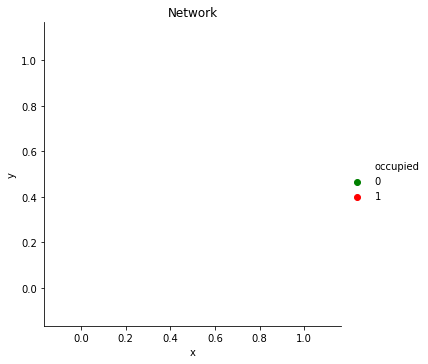

In [449]:
n = Network(nodes_path = "/Users/owner/Project/nodes.csv",edges_path = "/Users/owner/Project/edges.csv")
n.run(minutes=30)
n.plot_network()

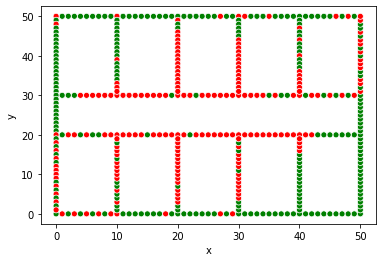

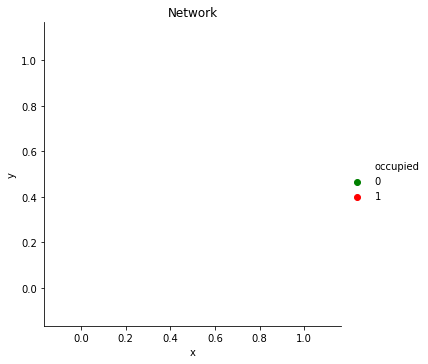

In [450]:
for index, row in n.edges.sort_values(by = ["from"]).iterrows():
    df = pd.DataFrame(np.array([]))
    from_id = row['from']
    to_id = row['to']
    a = pd.DataFrame(np.array([ [n.segments[from_id].x, n.segments[from_id].y]] ))
    b = pd.DataFrame(np.array([ [n.segments[to_id].x, n.segments[to_id].y]] ))
    df = df.append(a)
    df = df.append(b)
    df.columns = ["x","y"]
    lineplot = plt.plot(df.x,df.y, color = "black")
    
lineplot
n.plot_network()

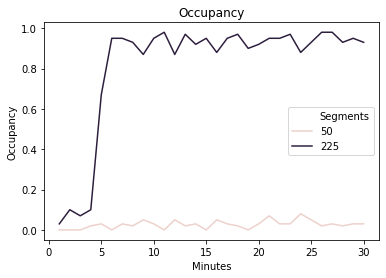

In [244]:
n.plot_occupancy([50,225])

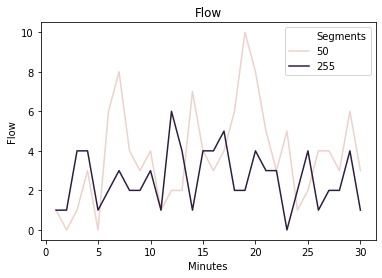

In [248]:
n.plot_flow([50,255])

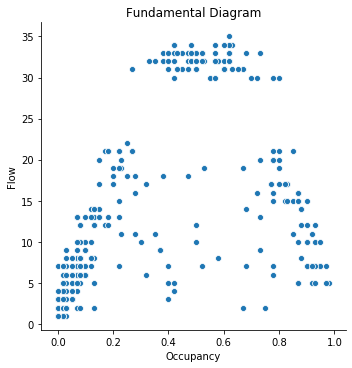

In [251]:
n.plot_fundamental_diagram(minute=10)